# Lab 6: Visualizing the training process of neural networks. Hyperparameter tuning.

In this lab, you will learn how to use [wandb](https://wandb.ai/) to visualize the training process of neural networks. We are going to build and train a feed-forward neural network for recognizing handwritten digits of the MNIST dataset. The training process will be visualized in the wandb dashboard, which will allow us to monitor the loss and accuracy of the model in real-time.

---



Feel free to create an account at [wandb.ai](https://wandb.ai/) before starting this lab.

### A simple example of how to use wandb in a typical training loop is shown below:

```python
import wandb

wandb.login() # Log in to your wandb account

# Start a new run

some_config = {
    'learning_rate': 0.01,
    'layer_1_size': 128,
    'layer_2_size': 64,
    'batch_size': 32
} # This is just an example of a configuration dictionary, you can put anything you want here

wandb.init(project='mnist-classifier', config=some_config) # start a new run and log parameters

# Here you would prepare your data, and initialize the model, optimizer, etc.

# Training loop
for epoch in range(100):
    ...
    wandb.log({'loss': loss, 'accuracy': accuracy})
    # This will send the loss and accuracy to wandb and you can visualize it in the dashboard

# End of the run
wandb.finish()
```

The most important part is the `wandb.log()` function, which sends the data to the wandb dashboard. You can log any metric you want, not just loss and accuracy. The value passed to the function must be a dictionary.


## Exercise 1: Prepare data for training a mnist classifier (2 points)

Before you start training a neural network, you need to prepare the data. In this exercise, you will prepare the MNIST dataset of handwritten digits for training a classifier. You should:

1. Load the MNIST dataset using from `data/mnist_train.csv` and `data/mnist_test.csv` files.
2. Normalize the data to the range [0, 1].
3. Encode the labels using one-hot encoding.
4. Create a PyTorch `Dataset` object for the training and test sets.
5. Create a PyTorch `DataLoader` object for the training and test sets.

In [1]:
# Your code goes here 
import pandas as pd
from sklearn import preprocessing
from torch.utils.data import DataLoader
import seaborn as sns 
import torch


data_train = pd.read_csv('data/mnist-train.csv') #wczytanie danych treningowych
train_label = data_train['label']
data_train = data_train.drop('label',axis=1)

data_test = pd.read_csv('data/mnist-test.csv') #wczytanie danych testowych
test_label = data_test['label']
data_test = data_test.drop('label',axis=1)

min_max_scaler = preprocessing.MinMaxScaler() #skalowanie danych
data_train_scaled = min_max_scaler.fit_transform(data_train)
data_test_scaled = min_max_scaler.fit_transform(data_test)

data_train_scaled = pd.DataFrame(data_train_scaled)
data_test_scaled = pd.DataFrame(data_test_scaled)

test_labels_encoded = pd.get_dummies(test_label) #one-hot encoding
train_labels_encoded = pd.get_dummies(train_label)


train_data_tensor = torch.tensor(data_train_scaled.values, dtype=torch.float32) #przekształcanie danych treningowych w tensor
test_data_tensor = torch.tensor(data_test_scaled.values, dtype=torch.float32) #przekształcanie danych testowych w tensor
train_labels_tensor = torch.tensor(train_labels_encoded.values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_tensor) #tworzenie datasetu treningowego
test_dataset = torch.utils.data.TensorDataset(test_data_tensor, test_labels_tensor) #tworzenie datasetu testowego


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #Data loader bierze małe zestawy danych z trainu 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Exercise 2: Prepare the architecture of the neural network (2 points)

In this exercise, you will prepare the architecture of the neural network. You should:

1. Create a neural network class that inherits from `torch.nn.Module`.
2. The neural network should have at least one hidden layer.
3. Use ReLU activation functions after each but the output layer.
4. Use a softmax activation function in the output layer to get the probabilities of each class.

**Feel free to experiment with the architecture of your network** - try adding more hidden layers, changing the number of neurons in each layer, etc. You can also add a dropout layer or some other regularization technique and see if it improves the performance of your model.

In [2]:
# Your code goes here

import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self,hidden_size):
        super(NeuralNetwork,self).__init__()
        self.fc1 = nn.Linear(784,hidden_size) #pierwsza liczba to z ilu zbiera, druga to ile percptronów zbiera
        self.fc2 = nn.Linear(hidden_size,10) #fc - fully conected 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        y  = self.fc1(x)
        y = self.relu(y)
        output = self.fc2(y)
        output = self.softmax(output)
        
        return output #nie dajemy nic, żadnej funkcji aktywacji to nie klasyfikacja typowa

## *Training PyTorch models on GPU

**GPUs are optimized for performing matrix operations in parallel.** Although we call them "graphics processing units", they are actually very powerful processors that can be used for any kind of parallel computation, including training deep neural networks. In fact, data science is one of the most common applications of GPUs today, as can be seen by the revenue of companies like NVIDIA over the past few years. NVIDIA is a monopolist in the GPU market - in 2023, the company owned 92% of the data center GPU market share. As for 31 July, the 2024 revenue of NVIDIA was 60.92 billion USD, while the total revenue of 2020 was $10.92 billion. If someone benefits from the current deep learning hype, it is certainly NVIDIA.

If you happen to have an NVIDIA GPU in your computer, you can use it to train your deep learning models, as PyTorch has excellent support for CUDA, which is NVIDIA's parallel computing API. To train a model on GPU, you need to explicitly tell PyTorch to move the model and the data to the GPU. 

Here is an example training loop that uses the GPU:

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # Check if a GPU is available

# Initialize the model and move it to the GPU
model = SomeNeuralNetwork().to(device)   # Move the model to the GPU

for epoch in range(100):
    for batch in data_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)   # Move the tensors to GPU
        
        y_pred = model(X)   # Perform a forward pass (on the GPU)
        loss = criterion(y_pred, y)   # Compute the loss (still on the GPU)
        
        ...  # The rest of the training loop
        
        y_pred = y_pred.detach().cpu()   # Move the predictions back to the CPU to do anything else with them
```

Note that **the model and all the tensors it uses for computation should be moved to the GPU**. You can do this by calling the `.to(device)` method on the model and the data tensors. If you want to move the data back to the CPU (to process it further, calculate metrics, visualize), you call the `.cpu()` method on the tensor.

**Doing calculations on the GPU, you should be wary of few things:**

* **The GPU has a limited amount of memory**, so you should be careful not to run out of memory. A typical graphics card has a few gigabytes of memory, so you should be fine with most models and datasets. However, moving very large tensors to the GPU can cause out-of-memory errors. That's one of the reasons why we use a dataloader and process the data in batches.
* While the GPU is much faster than the CPU for large matrix operations, **transferring data between the CPU and the GPU is slow**. Therefore, it is best to minimize the number of data transfers between the CPU and the GPU.

## Exercise 3: Prepare the training loop (2 points)

In this exercise, you will prepare the training loop. You should:

1. Initialize the neural network.
2. Define the loss function.
3. Define the optimizer.
4. Pass a dictionary with the configuration to wandb. This dictionary should contain all the hyperparameters of our model, including the learning rate, the size of the hidden layers, batch size, etc.
4. Train the neural network. Each epoch should consist of a training and validation phase. You should log the loss and accuracy of the training and validation sets using wandb.
5. Open you project at [wandb.ai](https://wandb.ai/) and see how cool it is!

### Saving and loading the model
As training can take some time, it is a good idea to save the model's state dictionary (its learned weights) to a file after training. You can do this with the following code:

    torch.save(vae.state_dict(), 'vae.pth')
    
To load the model from the file, you can use the following code:

    vae.load_state_dict(torch.load('vae.pth'))

In [3]:
# Your code goes here
def train(model, train_loader, tesr_loader, epochs=10):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()
    
    
    train_loss_history = []
    test_loss_history = []
    
    
    for epoch in range(epochs):
        
        model.train()   # set the model to training mode (some layers may behave differently in training and evaluation)
        train_loss = 0  # this variable will accumulate the training loss
        
        for X_batch, y_batch in train_loader:   # load data batch-by-batch

            tensor = torch.tensor([0,0,0,0,0,0,0,0,0,0])
            optimizer.zero_grad()   # clear the gradients
            y_pred = model(X_batch)  # forward pass
            batch_loss = loss(y_pred, y_batch) # compute the loss
            batch_loss.backward()   # compute the gradients
            optimizer.step()    # update the weights
            train_loss += batch_loss.item()# accumulate training loss
            
            
        
        train_loss = train_loss / len(train_loader) # compute the average loss
        train_loss_history.append(train_loss)   # save the loss for plotting
        print(f'Epoch: {epoch}')
        print(f'Train loss: {train_loss}')
        
                  
        model.eval()    # set the model to evaluation mode
        test_loss = 0    # this variable will accumulate the validation loss
        
        for X_batch, y_batch in test_loader:
            
            y_pred = model(X_batch)
            test_loss += loss(y_pred, y_batch).item()    # accumulate validation loss
            
        test_loss = test_loss / len(test_loader)
        test_loss_history.append(test_loss)   # save the loss for plotting
        print(f'Test loss: {test_loss}')
        
    return model, train_loss_history, test_loss_history
...

Ellipsis

In [4]:
model = NeuralNetwork(hidden_size=100)
model, train_metrics, test_metrics = train(model, train_loader, test_loader)

Epoch: 0
Train loss: 0.042495288248856865
Test loss: 0.03687215178012848
Epoch: 1
Train loss: 0.03862071486612161
Test loss: 0.03570543369054794
Epoch: 2
Train loss: 0.037710708063840866
Test loss: 0.0352687539100647
Epoch: 3
Train loss: 0.03735424966712793
Test loss: 0.03513940716981888
Epoch: 4
Train loss: 0.03715156038949887
Test loss: 0.03503180093169212
Epoch: 5
Train loss: 0.036725364392995834
Test loss: 0.034827121311426165
Epoch: 6
Train loss: 0.03666546948552132
Test loss: 0.034803648459911345
Epoch: 7
Train loss: 0.03655728881210089
Test loss: 0.03467141073644161
Epoch: 8
Train loss: 0.03644591064701478
Test loss: 0.03463110978901386
Epoch: 9
Train loss: 0.03609862341632446
Test loss: 0.03459358521997929


Text(0, 0.5, 'MSE Loss')

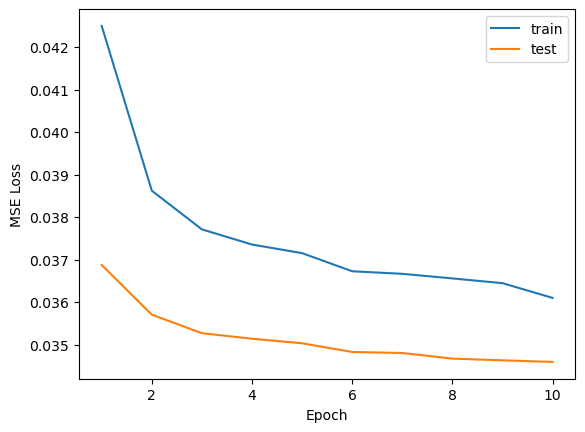

In [5]:
# plot the training and validation loss

import matplotlib.pyplot as plt

plot_df = pd.DataFrame({'epoch': range(1, len(train_metrics) + 1), 
                        'train_loss': train_metrics, 
                        'test_loss': test_metrics})

sns.lineplot(data=plot_df, x='epoch', y='train_loss', label='train')
sns.lineplot(data=plot_df, x='epoch', y='test_loss', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

Predicted value: 2


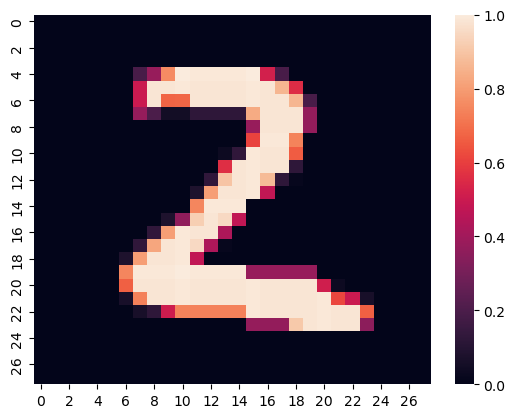

In [7]:
import numpy as np
img_to_pred = test_data_tensor[945]

nums = np.array(range(10))
output = model(img_to_pred).tolist()
pred_val = nums[np.argmax(output)]

sns.heatmap(torch.reshape(img_to_pred,(28,28)))
print(f'Predicted value: {pred_val}')

## Exercise 4: Easy hyperparameter tuning with wandb (2 points)

Wandb allows you to perform hyperparameter tuning by automatically creating multiple runs with different hyperparameters and logging the performance of each run. Below is a brief instruction to `wandb` hyperparameter tuning, but you are more than welcome to find more information in the [official wandb guide](https://docs.wandb.ai/guides/sweeps/).

Your task is to use wandb to perform hyperparameter tuning of the neural network, trying different values of the learning rate, batch size, and the size of the hidden layers. You can use the following hyperparameters:

First, we need to define a dictionary with the hyperparameters that we want to tune. For example:

```python
parameters = {
    'learning_rate': {'values': [0.01, 0.001, 0.0001]},
    'batch_size': {'values': [32, 64, 128]},
    'layer_1_size': {'values': [64, 128, 256]},
    'layer_2_size': {'values': [32, 64, 128]}
}
```

Then we need to create a dictionary with the configuration of the run:

```python
sweep_config = {
    'name': 'mnist-sweep',
    'method': 'grid',   # grid search, you can also try 'random' or 'bayes'
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters': parameters,   # that's the dictionary with the hyperparameters
}
```

Finally, we can use the `wandb.sweep` function to perform hyperparameter tuning:

```python
sweep_id = wandb.sweep(sweep_config, project='mnist-classifier')
```

After that, we can finally run the sweep:

```python
wandb.agent(sweep_id, function=train)
```
where `train` is a function that trains the model and logs the metrics to wandb. This function should take a `config` argument, which will contain the hyperparameters of the run. That is how wandb knows which hyperparameters to tune.

1. Rewrite the VAE training loop into a function that takes a single dictionary `parameters` as an argument, initializes the model, optimizer, and criterion, and trains the model for a fixed number of epochs. The function should log the loss and accuracy of the training and validation sets to wandb.
2. Create a dictionary with the hyperparameters that you want to tune.
3. Create a sweep configuration dictionary.
4. Run the sweep and monitor the results in the wandb dashboard.

In [ ]:
import wandb

def train(parameters: dict):
    
    # your code goes here
    ...

In [ ]:
parameters = {...}

sweep_config = {
    'name': 'mnist-sweep',
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': 'accuracy'}, # if we want to maximize the accuracy
    # remember to log the metric that you want to maximize or minimize!
    'parameters': parameters,
}

sweep_id = wandb.sweep(sweep_config, project='mnist-classifier')    # This will create a new sweep
wandb.agent(sweep_id, function=train)   # This will start the hyperparameter tuning process